In [2]:
import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_24847/3888904027.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [3]:
#User Input
sim = input("DR2 or DR3: ")
dim = input("Input how many dimensions are needed: ")
galaxy = input("Use m12i or m12f data: ")
transfer = bool(input("Transfer learning (True or False): "))
if transfer == True:
    transfer_galaxy = input("Which galaxy parameters for transfer learning: ")

DR2 or DR3: DR2
Input how many dimensions are needed: 4
Use m12i or m12f data: m12f
Transfer learning (True or False): True
Which galaxy parameters for transfer learning: m12i


In [27]:
# Training data
if dim == '4':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec']
elif dim == '5':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
elif dim == '6':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '7':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'feh']
elif dim == '9':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz']
elif dim == '10':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz', 'feh']
    
y_key = 'is_accreted'

# Directories
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/Ananke'+ sim + '_data_reduced_' + galaxy + '.hdf5'
out_dir = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim + 'D'
roc_title = sim + '_' + galaxy
    
train_parameter_file = out_dir + '/training_parameters.hdf5'
train_log = out_dir + '/training_logs'

checkpoint = train_log + '/version_0/checkpoints/last.ckpt'
roc_title = sim + '_' + transfer_galaxy + '_on_' + galaxy

# Parameters
learning_rate = 1e-3
batch_size = 1024
roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + 'roc_parameters.hdf5'

if transfer == True:
    out_dir = out_dir + '_transfer'
    transfer_checkpoint = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim +'/'+ transfer_galaxy +'/'+ dim + 'D/training_logs/version_0/checkpoints/last.ckpt'
    roc_title = sim + '_' + transfer_galaxy + '_on_' + galaxy + '_' + dim + 'D'
    roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + roc_title + 'roc_parameters.hdf5'
    
#Saving roc curves
def save_roc(roc_path, epsilon_i, epsilon_a):
    with h5py.File(roc_path, 'a') as f:
        if dim + 'D_ep_i' in f.keys():
            del f[dim + 'D_ep_i']
            del f[dim + 'D_ep_a']
            f.create_dataset(dim + 'D_ep_i', data=epsilon_i)
            f.create_dataset(dim + 'D_ep_a', data=epsilon_a)
        else:
            f.create_dataset(dim + 'D_ep_i', data=epsilon_i)
            f.create_dataset(dim + 'D_ep_a', data=epsilon_a)
            


In [5]:
data = []
f = h5py.File(path, 'r')

for i in x_keys:
    data.append(f[i][:])
y = f[y_key][:]

In [6]:
# Getting rid of nan values
x = []
if 'Jr' in x_keys:
    Jr = f['Jr'][:]
    mask = (~np.isnan(Jr))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
elif 'radial_velocity' in x_keys:
    rv = f['radial_velocity'][:]
    mask = (~np.isnan(rv))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
else:
    x = data

x = np.vstack(x).T
f.close()

In [7]:
shuffle = np.random.permutation(len(x))
x = x[shuffle]
y = y[shuffle]

In [8]:
# with h5py.File(train_parameter_file, 'r') as f:
# shuffle = f['shuffle'][:]

# x = x[shuffle]
# y = y[shuffle]

In [9]:
n_train = int(0.9 *len(x))
n_val = len(x)-n_train
train_x, val_x = x[:n_train], x[n_train: n_train+n_val]
train_y, val_y = y[:n_train], y[n_train: n_train+n_val]

In [10]:
ny1 = np.sum(train_y==1)
ny0 = np.sum(train_y==0)
ny = ny1 + ny0
w1 = ny/ny1
w0 = ny/ny0
weight = torch.tensor([w0, w1], dtype=torch.float32)

In [11]:
mean_train_x = np.mean(train_x, axis = 0)
stdv_train_x = np.std(train_x, axis = 0)
train_x = (train_x - mean_train_x) / stdv_train_x
val_x = (val_x - mean_train_x) / stdv_train_x
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.long)

In [12]:
weight

tensor([ 1.0207, 49.3390])

In [13]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [14]:
with h5py.File(train_parameter_file, 'w') as f:
    f.create_dataset('shuffle', data=shuffle)
    f.attrs['n_train']=n_train
    f.attrs['n_val']=n_val

In [15]:
class Model(LightningModule):
    def __init__(self, transfer):
        self.feature_extractor = FeatureExtractorModel()
        self.classifier = Classifier
        if transfer:
             self.feature_extractor.freeze()
                
    def __init__(self, weight, mean_train_x, stdv_train_x):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(len(x_keys), 100) 
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 2)
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.weight = weight
        self.mean_train_x = mean_train_x
        self.stdv_train_x = stdv_train_x

    def forward(self, x):
        x_out = self.l1(x)
        x_out = torch.relu(x_out)
        x_out = self.l2(x_out)
        x_out = torch.relu(x_out)
        x_out = self.l3(x_out)
        return x_out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_nb):
        train_x, train_y = batch 
        preds = self(train_x)
        loss = F.cross_entropy(preds, train_y, weight = self.weight.to(self.device))
        self.train_acc(preds, train_y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        val_x, val_y = batch
        preds = self(val_x)
        loss = F.cross_entropy(preds, val_y, weight=self.weight.to(self.device))
        self.valid_acc(preds, val_y)
        self.log('val_loss', loss)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [ ]:
if transfer == True:
    model = Model.load_from_checkpoint(transfer_checkpoint, transfer=True)
else:
    model = Model(transfer=False)

# Create trainer
callbacks = [
    ModelCheckpoint(
        monitor="val_loss", mode='min', filename="{epoch}-{val_loss:.4f}",
        save_top_k=3, save_last=True, save_weights_only=True),
    EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, mode='min', verbose=True)
]
trainer_logger = CSVLogger(out_dir, name=train_log)
trainer = Trainer(
    accelerator="auto", devices=1 if torch.cuda.is_available() else None,
    max_epochs=10, default_root_dir=out_dir,
    callbacks=callbacks, logger=trainer_logger, enable_progress_bar=True )

# Start training
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | l1        | Linear   | 500   
1 | l2        | Linear   | 5.0 K 
2 | l3        | Linear   | 102   
3 | train_acc | Accuracy | 0     
4 | valid_acc | Accuracy | 0     
---------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/jet/home/hsu1/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/jet/home/hsu1/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.316


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.314


In [16]:
model = Model.load_from_checkpoint(checkpoint)
mean = model.mean_train_x
stdv = model.stdv_train_x
weight = model.weight

In [17]:
n_test = n_val
test_x = x[n_train: n_train+n_test]
test_y = y[n_train: n_train+n_test]

test_x = (test_x - mean) / stdv

test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.long)

test_dataset = list(zip(test_x, test_y))
test_loader = DataLoader(test_dataset, batch_size = batch_size)

In [18]:
predict = []
target = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        yhat = model(x)
        predict.append(yhat.cpu().numpy())
        target.append(y.cpu().numpy())
predict = np.concatenate(predict)
target = np.concatenate(target)

score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))

score_a = score[target==True]
score_i = score[target==False]

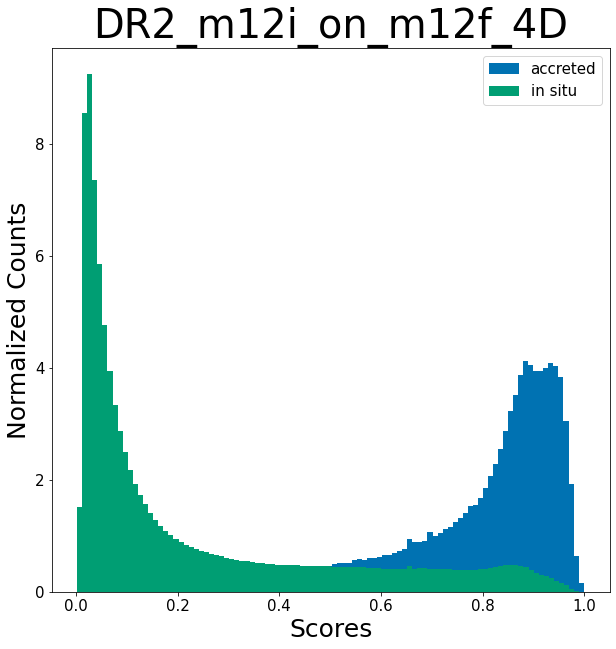

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.hist(score_a, bins=100, density=True, label='accreted')
ax.hist(score_i, bins=100, density=True, label='in situ')
ax.set_title(roc_title, fontsize=40)
ax.set_xlabel('Scores', fontsize=25)
ax.set_ylabel('Normalized Counts', fontsize=25)
ax.tick_params(axis='both', labelsize=15)
#plt.xlim([0,1])
# plt.ylim([0,25])
ax.legend(loc='upper right', fontsize=15)

In [20]:
target_true_mask = (target==True)
target_false_mask = (target==False)

thresholds = np.linspace(0.001, 1, 100)
precision = []
recall = []
epsilon_a = []
epsilon_i = []
for thres in thresholds:
    score_1 = score>thres
    score_1_true_mask = (score_1==True)
    score_1_false_mask = (score_1==False)
    TP = np.sum(score_1[target_true_mask])
    FP = np.sum(score_1[target_false_mask])
    TN = np.sum(~score_1[target_false_mask])
    FN = np.sum(~score_1[target_true_mask])
#     precision_thres = TP / (TP + FP)
#     recall_thres = TP / (TP + FN)
#     precision.append(precision_thres)
#     recall.append(recall_thres)
    N_a = TP + FN
    N_i = TN + FP
    N_a_s = TP
    N_i_s = FP
    epsilon_a_thres = N_a_s / N_a
    epsilon_i_thres = N_i_s / N_i
    epsilon_a.append(epsilon_a_thres)
    epsilon_i.append(epsilon_i_thres)

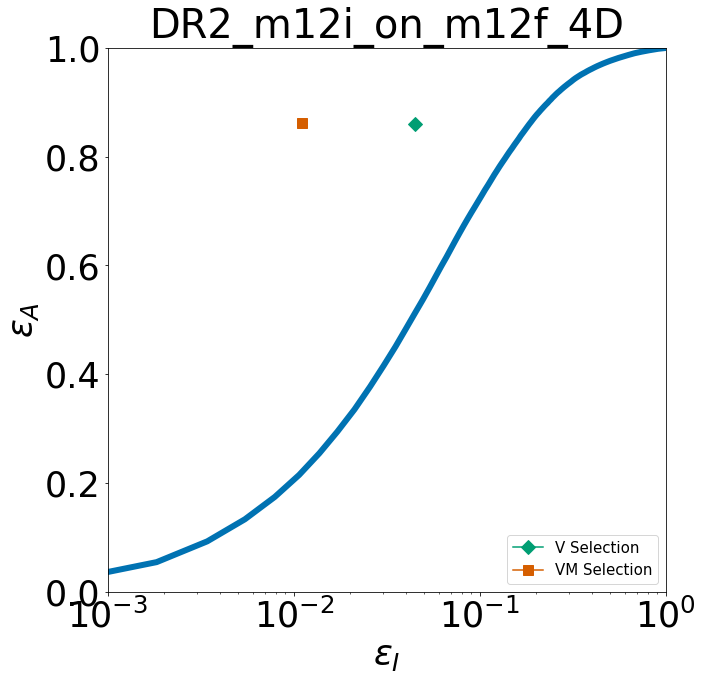

In [29]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.plot(epsilon_i, epsilon_a, linewidth=6)
ax.plot(0.045, 0.86, markersize=10, marker='D', label='V Selection')
ax.plot(0.011, 0.862, markersize=10, marker='s', label='VM Selection')
#ax.plot(0.3, 0.1, markersize=20, marker=(5, 1))
ax.set_title(roc_title, fontsize=40)
ax.set_xlabel(r'$\epsilon_I$', fontsize=35)
ax.set_ylabel(r'$\epsilon_A$', fontsize=35)
ax.set_xscale('log')
ax.tick_params(axis='both', labelsize=35)
ax.legend(fontsize=15, loc='lower right')
plt.xlim([0.001,1])
plt.ylim([0,1])
plt.show()



In [19]:
save_roc(roc_path, epsilon_i, epsilon_a)